      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0               7.4             0.700         0.00             1.9      0.076  \
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  

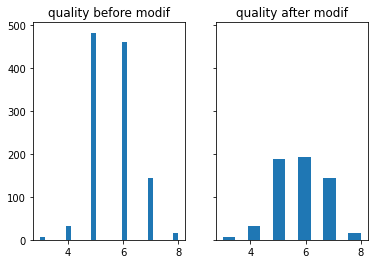

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('WineQT.csv')
print(df)
import numpy as np
import matplotlib.pyplot as plt
# load the dataset

y_train = df['quality']
X_train= [df['volatile acidity'],df['alcohol'],df['sulphates'],df['citric acid']]
X_features = ['volatile acidity','alcohol','sulphates','citric acid']
X_train=np.transpose(np.asmatrix(X_train))
y_train=np.asarray(y_train)


def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(X_norm)
import random
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(df["quality"], bins='auto',label="quality")
ax[0].set_title("quality before modif")
supp=[]
#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 3)
for i in range(len(y_train)):
    if y_train[i]==5 or y_train[i]==6:
        rand=random.random()
        if(rand>0.4):
            supp.append(i)
for j in range(len(supp)):
    y_train2=np.delete(y_train,supp)
    X_norm2=np.delete(X_norm,supp,0)


ax[1].hist(y_train2, bins='auto',label="quality")
ax[1].set_title("quality after modif")

print(y_train2.shape)
print(X_norm2.shape)

DIVISION DU JEU DE DONNEES EN TRAIN SET, CROSS VALIDATION ET TEST SET:

In [3]:
print(X_norm2.shape)
print(y_train2.shape)

debutcv=int(X_norm2.shape[0]*0.6)
debuttest=int(X_norm2.shape[0]*0.8)

X_train=X_norm2[0:debutcv]
X_cv=X_norm2[debutcv:debuttest]
X_test=X_norm2[debuttest:]

y_train=y_train2[0:debutcv]
y_cv=y_train2[debutcv:debuttest]
y_test=y_train2[debuttest:]

print(X_train.shape,X_cv.shape,X_test.shape)
print(y_train.shape,y_cv.shape,y_test.shape)

(579, 4)
(579,)
(347, 4) (116, 4) (116, 4)
(347,) (116,) (116,)


Creation de 3 modèles à comparer:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from IPython.display import display, Markdown, Latex
from matplotlib.widgets import Slider
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

2023-04-19 09:48:21.197786: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 09:48:21.513388: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 09:48:21.514567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 09:48:23.429292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
tf.random.set_seed(20)

In [16]:

def build_models():
    
    model_1 = Sequential(
        [
            tf.keras.Input(shape=(4,)),
            Dense(25, activation = 'relu'),
            Dense(15, activation = 'relu'),
            Dense(9, activation = 'softmax')
        ],
        name='model_1'
    )
    model_2 = Sequential(
        [
            tf.keras.Input(shape=(4,)),
            Dense(20, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(20, activation = 'relu'),
            Dense(9, activation = 'softmax')
        ],
        name='model_2'
    )
    model_3 = Sequential(
        [
            tf.keras.Input(shape=(4,)),
            Dense(32, activation = 'relu'),
            Dense(16, activation = 'relu'),
            Dense(8, activation = 'relu'),
            Dense(4, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(9, activation = 'softmax')
        ],
        name='model_3'
    )
    
    model_list = [model_1, model_2, model_3]

    return model_list

In [6]:
def locateMax(tab):
    max=0
    for loop in range(len(tab)):
        if tab[loop]>tab[max]:
            max=loop
    return max

In [7]:
def calcul_error(y,yp):
    m=len(y)
    sum=0
    for loop in range(m):
        if(yp[loop] != y[loop]):
            sum+=1
    return((sum/m)*100)

In [18]:

from sklearn.metrics import mean_squared_error
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []


# Build the models
nn_models = build_models()

# Loop over the the models
for model in nn_models:
    
    # Setup the loss and optimizer
    model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    print(f"Training {model.name}...")
    
    
    # Train the model
    model.fit(
        X_train, y_train,
        epochs=200,
        verbose=0
    )
    
    print("Done!\n")

    # Set the threshold for classification
    threshold = 0.5
    # Record the fraction of misclassified examples for the training set
    predictions = model.predict(X_train)
    yhat= np.zeros(len(predictions))

    for loop in range(len(predictions)):
        yhat[loop]=locateMax(predictions[loop])
    #print(yhat)

    train_error = calcul_error(yhat,y_train)
    nn_train_error.append(train_error)

    # Record the fraction of misclassified examples for the cross validation set
    predictions = model.predict(X_cv)
    yhat= np.zeros(len(predictions))

    for loop in range(len(predictions)):
        yhat[loop]=locateMax(predictions[loop])
    #print(yhat)

    cv_error = calcul_error(yhat,y_cv)
    nn_cv_error.append(cv_error)

    
# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

Training model_1...
Done!

4/4 [==============================] - 0s 5ms/step
Training model_2...
Done!

4/4 [==============================] - 0s 4ms/step
Training model_3...
Done!

4/4 [==============================] - 0s 6ms/step
Model 1: Training Set Classification Error: 21.03746, CV Set Classification Error: 52.58621
Model 2: Training Set Classification Error: 14.40922, CV Set Classification Error: 49.13793
Model 3: Training Set Classification Error: 10.66282, CV Set Classification Error: 59.48276


In [19]:
# Select the model with the lowest error
model_num = 2

# Compute the test error
predictions = model.predict(X_test)
yhat= np.zeros(len(predictions))

for loop in range(len(predictions)):
    yhat[loop]=locateMax(predictions[loop])
print(yhat)
print(y_test)
nn_test_error =calcul_error(yhat,y_test)

print(f"Selected Model: {model_num}")
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

4/4 [==============================] - 0s 3ms/step
[6. 5. 7. 6. 5. 5. 5. 6. 5. 5. 4. 5. 5. 5. 6. 6. 5. 5. 5. 6. 6. 6. 7. 6.
 5. 5. 5. 5. 8. 7. 5. 5. 6. 5. 6. 7. 5. 5. 5. 5. 7. 7. 7. 7. 7. 6. 6. 7.
 6. 7. 5. 6. 6. 7. 7. 6. 6. 5. 5. 5. 6. 5. 7. 7. 6. 7. 6. 5. 6. 6. 4. 6.
 5. 5. 6. 7. 7. 5. 7. 6. 5. 6. 6. 6. 7. 6. 5. 4. 6. 7. 5. 7. 7. 5. 5. 5.
 6. 5. 5. 5. 6. 5. 4. 5. 5. 7. 7. 5. 7. 6. 6. 7. 7. 7. 6. 7.]
[6 5 6 6 5 6 3 6 5 5 6 5 6 6 6 6 5 5 5 6 6 6 5 5 5 5 5 6 6 6 5 6 6 5 5 6 5
 6 5 5 6 8 6 7 6 6 6 6 5 7 5 5 5 6 4 7 6 5 6 5 8 7 7 7 6 7 6 4 5 7 4 7 3 5
 5 7 7 3 5 4 5 5 7 6 6 6 3 6 6 6 6 6 6 6 5 7 7 5 8 5 7 5 6 5 5 6 6 6 6 6 5
 7 6 6 6 6]
Selected Model: 2
Training Set Classification Error: 14.4092
CV Set Classification Error: 49.1379
Test Set Classification Error: 52.5862


VISUALISATION TEST DU MODELE CHOISI 

4/4 [==============================] - 0s 3ms/step
(116, 4) (116,) (116,)


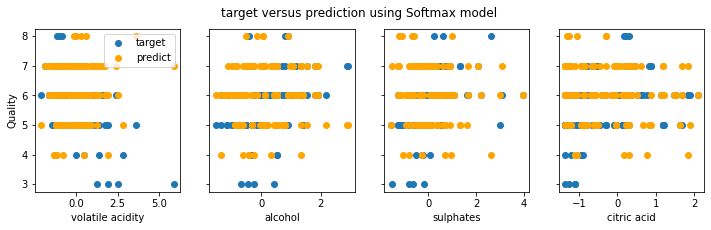

In [20]:

predictions = model.predict(X_cv)
yhat= np.zeros(len(predictions))

for loop in range(len(predictions)):
    yhat[loop]=locateMax(predictions[loop])

print(X_test.shape, y_test.shape,yhat.shape)


m = X_test.shape[0]

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter([X_test[:,i]],y_test, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter([X_test[:,i]],yhat,color="orange", label = 'predict')
ax[0].set_ylabel("Quality"); ax[0].legend()
fig.suptitle("target versus prediction using Softmax model")
plt.show()

FIXER BIAIS ET VARIANCES:

In [21]:
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

Training Set Classification Error: 14.4092
CV Set Classification Error: 49.1379
Test Set Classification Error: 52.5862


vu que Jcv (49.1379) est grand par rapport à Jtrain (14.4092), on a une grande variance, on va donc rajouter un parametre de régularisation Lambda en gardant le meme model.

In [ ]:
from tensorflow.keras.regularizers import L2
def build_models_Regularized():
    lambdas=[0.01,0.1,1]
    model_1 = Sequential(
        [
            tf.keras.Input(shape=(4,)),
            Dense(20, activation = 'relu',kernel_regularized=L2(lambdas[0])),
            Dense(12, activation = 'relu',kernel_regularized=L2(lambdas[0])),
            Dense(12, activation = 'relu',kernel_regularized=L2(lambdas[0])),
            Dense(20, activation = 'relu',kernel_regularized=L2(lambdas[0])),
            Dense(9, activation = 'softmax')
        ],
        name='model_1'
    )
    model_2 = Sequential(
        [
            tf.keras.Input(shape=(4,)),
            Dense(20, activation = 'relu',kernel_regularized=L2(lambdas[1])),
            Dense(12, activation = 'relu',kernel_regularized=L2(lambdas[1])),
            Dense(12, activation = 'relu',kernel_regularized=L2(lambdas[1])),
            Dense(20, activation = 'relu',kernel_regularized=L2(lambdas[1])),
            Dense(9, activation = 'softmax')
        ],
        name='model_2'
    )
    model_3 = Sequential(
        [
            tf.keras.Input(shape=(4,)),
            Dense(20, activation = 'relu',kernel_regularized=L2(lambdas[2])),
            Dense(12, activation = 'relu',kernel_regularized=L2(lambdas[2])),
            Dense(12, activation = 'relu',kernel_regularized=L2(lambdas[2])),
            Dense(20, activation = 'relu',kernel_regularized=L2(lambdas[2])),
            Dense(9, activation = 'softmax')
        ],
        name='model_3'
    )
    model_list = [model_1, model_2, model_3]
    return model_list